In [ ]:
#COMPARER SMOTE ET SMOTTEEN POUR AJUSTER LE DESEQUILIBRE DES CLASSES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GroupShuffleSplit


# ---------------------------
# 1. Configuration
# ---------------------------
SEED = 42
np.random.seed(SEED)

# ---------------------------
# 2. Chargement des données
# ---------------------------
from google.colab import files

# 2. IMPORT DU FICHIER
uploaded = files.upload()
df = pd.read_csv("data_features_standardise.csv")

# ---------------------------
# 3. Attribution ID patients
# ---------------------------
patient_ids = [i for i in range(13) for _ in range(45)] + [13] * 9
df["Patient_ID"] = patient_ids

# ---------------------------
# 4. Définition des variables
# ---------------------------
features = [
    "Age", "BV/TV", "Tb.Th mean (mm)", "Tb.Sp mean (mm)", "Conn.D (mm^-3)",
    "Z-score", "Gradient_ant_post_BVTV", "Gradient_ant_post_Tb.Th",
    "Fragilité_moyenne", "Ratio_compacite"
]
target_class = "Risk"
target_score = "T-score"

# ---------------------------
# 5. Split patient-wise
# ---------------------------
patient_class_0_indicator = df.groupby('Patient_ID')['Risk'].apply(lambda x: 0 in x.values).astype(int)
patient_train_ids, patient_test_ids = train_test_split(
    np.unique(df['Patient_ID']),
    test_size=0.3,
    random_state=SEED,
    stratify=patient_class_0_indicator.loc[np.unique(df['Patient_ID'])]
)
df_train = df[df["Patient_ID"].isin(patient_train_ids)]
df_test = df[df["Patient_ID"].isin(patient_test_ids)]

# ---------------------------
# 6. Stratified Split
# ---------------------------
X_train_full = df_train[features].values
y_train_class_full = df_train[target_class].astype(int).values
y_train_score_full = df_train[target_score].values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(X_train_full, y_train_class_full))

X_train_raw = X_train_full[train_idx]
y_train_class_raw = y_train_class_full[train_idx]
y_train_score_raw = y_train_score_full[train_idx]

X_val = X_train_full[val_idx]
y_val_class = y_train_class_full[val_idx]
y_val_score = y_train_score_full[val_idx]

X_test = df_test[features].values
y_test_class = df_test[target_class].astype(int).values
y_test_score = df_test[target_score].values

# ---------------------------
# 7. Fonction utilitaire : reconstituer les T-scores
# ---------------------------
def reconstitute_scores(X_resampled, X_raw, y_score_raw, features):
    df_raw = pd.DataFrame(X_raw, columns=features)
    df_raw['T-score'] = y_score_raw
    df_resampled = pd.DataFrame(X_resampled, columns=features)
    df_merged = df_resampled.merge(df_raw, on=features, how='left')
    df_merged['T-score'] = df_merged['T-score'].fillna(df_raw['T-score'].mean())
    return df_merged['T-score'].values

# ---------------------------
# 8. Fonction principale d'entraînement/évaluation
# ---------------------------
def train_and_evaluate_model(X_train, y_train_class, y_train_score,
                             X_val, y_val_class, y_val_score,
                             X_test, y_test_class, y_test_score,
                             class_weight_dict, early_stop, method_name):
    print(f"\n--- Entraînement et évaluation avec {method_name} ---")

    # Modèle Classification
    input_layer = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(3, activation='softmax')(x)
    model_class = Model(inputs=input_layer, outputs=output_layer)
    model_class.compile(optimizer=Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    model_class.fit(X_train, y_train_class,
                    validation_data=(X_val, y_val_class),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop],
                    verbose=0)

    # Évaluation Classification
    pred_risk_probs = model_class.predict(X_test)
    pred_risk = np.argmax(pred_risk_probs, axis=1)
    print("\n--- Classification ---")
    print(f"Accuracy: {np.mean(pred_risk == y_test_class):.4f}")
    print("Classification Report:")
    print(classification_report(y_test_class, pred_risk))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_class, pred_risk))
    print(f"MCC: {matthews_corrcoef(y_test_class, pred_risk):.4f}")
    y_test_bin = label_binarize(y_test_class, classes=[0, 1, 2])
    print(f"ROC AUC (macro): {roc_auc_score(y_test_bin, pred_risk_probs, average='macro', multi_class='ovr'):.4f}")

    # Modèle Régression
    input_layer_reg = Input(shape=(X_train.shape[1],))
    x_reg = Dense(64, activation='relu')(input_layer_reg)
    x_reg = Dense(32, activation='relu')(x_reg)
    output_layer_reg = Dense(1)(x_reg)
    model_reg = Model(inputs=input_layer_reg, outputs=output_layer_reg)
    model_reg.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['mae'])
    model_reg.fit(X_train, y_train_score,
                  validation_data=(X_val, y_val_score),
                  epochs=100,
                  batch_size=32,
                  callbacks=[early_stop],
                  verbose=0)

    # Évaluation Régression
    pred_tscore = model_reg.predict(X_test).flatten()
    print("\n--- Régression ---")
    print(f"MAE:  {mean_absolute_error(y_test_score, pred_tscore):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test_score, pred_tscore)):.4f}")
    print(f"R²:   {r2_score(y_test_score, pred_tscore):.4f}")

# ---------------------------
# 9. Poids des classes
# ---------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_class_raw),
    y=y_train_class_raw
)
class_weight_dict = dict(zip(np.unique(y_train_class_raw), class_weights))

# ---------------------------
# 10. Callback EarlyStopping
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ---------------------------
# 11. SMOTE
# ---------------------------
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_class_smote = smote.fit_resample(X_train_raw, y_train_class_raw)
y_train_score_smote = reconstitute_scores(X_train_smote, X_train_raw, y_train_score_raw, features)

train_and_evaluate_model(X_train_smote, y_train_class_smote, y_train_score_smote,
                         X_val, y_val_class, y_val_score,
                         X_test, y_test_class, y_test_score,
                         class_weight_dict, early_stop, "SMOTE")

# ---------------------------
# 12. SMOTEENN
# ---------------------------
smoteenn = SMOTEENN(random_state=SEED)
X_train_smoteenn, y_train_class_smoteenn = smoteenn.fit_resample(X_train_raw, y_train_class_raw)
y_train_score_smoteenn = reconstitute_scores(X_train_smoteenn, X_train_raw, y_train_score_raw, features)

train_and_evaluate_model(X_train_smoteenn, y_train_class_smoteenn, y_train_score_smoteenn,
                         X_val, y_val_class, y_val_score,
                         X_test, y_test_class, y_test_score,
                         class_weight_dict, early_stop, "SMOTEENN")



--- Entraînement et évaluation avec SMOTE ---


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Classification ---
Accuracy: 0.8400
Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        45
           1       1.00      0.73      0.85       135
           2       0.70      1.00      0.83        45

    accuracy                           0.84       225
   macro avg       0.81      0.91      0.84       225
weighted avg       0.89      0.84      0.84       225

Confusion Matrix:
[[45  0  0]
 [17 99 19]
 [ 0  0 45]]
MCC: 0.7693
ROC AUC (macro): 0.9967


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- Régression ---
MAE:  0.7255
RMSE: 0.8427
R²:   0.2252

--- Entraînement et évaluation avec SMOTEENN ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Classification ---
Accuracy: 0.7867
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        45
           1       1.00      0.64      0.78       135
           2       0.58      1.00      0.73        45

    accuracy                           0.79       225
   macro avg       0.78      0.88      0.79       225
weighted avg       0.87      0.79      0.79       225

Confusion Matrix:
[[45  0  0]
 [15 87 33]
 [ 0  0 45]]
MCC: 0.7110
ROC AUC (macro): 0.9991
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Régression ---
MAE:  0.7467
RMSE: 0.8997
R²:   0.1169


Saving data_features_standardise.csv to data_features_standardise (1).csv


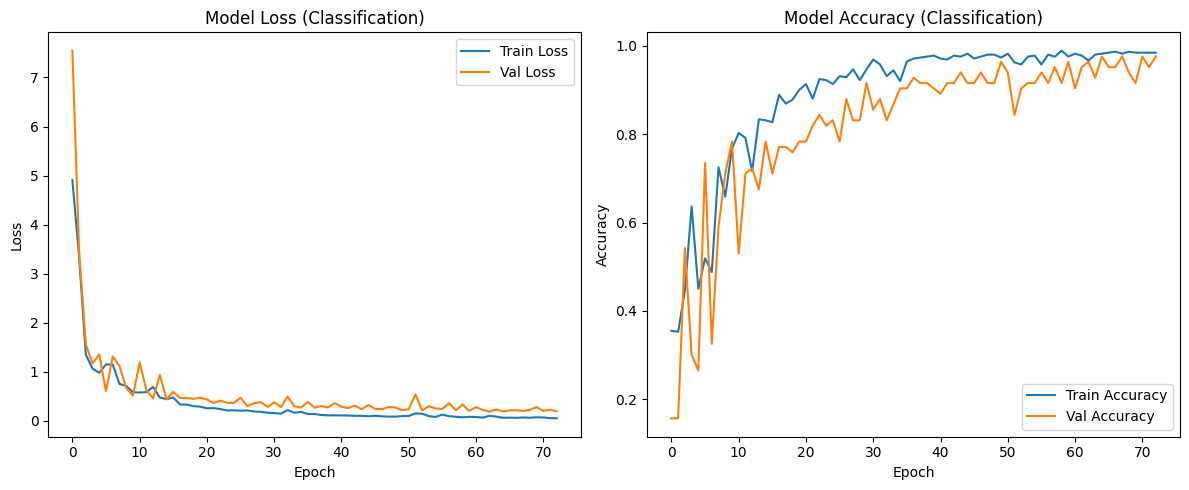

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
--- Classification ---
Accuracy: 0.9609 | MCC: 0.9374 | ROC AUC: 0.9968
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        27
           1       0.97      0.93      0.95        68
           2       1.00      0.99      0.99        84

    accuracy                           0.96       179
   macro avg       0.94      0.96      0.95       179
weighted avg       0.96      0.96      0.96       179

Confusion Matrix:
[[26  1  0]
 [ 5 63  0]
 [ 0  1 83]]


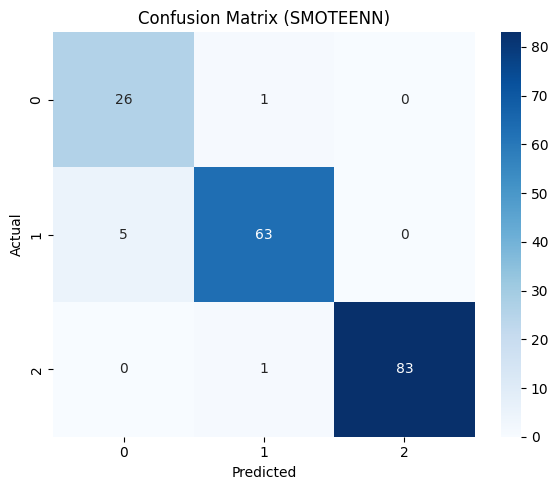

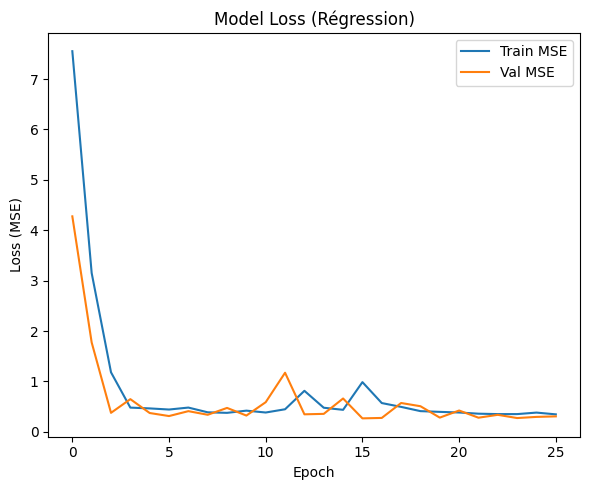

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

--- Régression ---
MAE: 0.3939 | RMSE: 0.5027 | R2: 0.7623


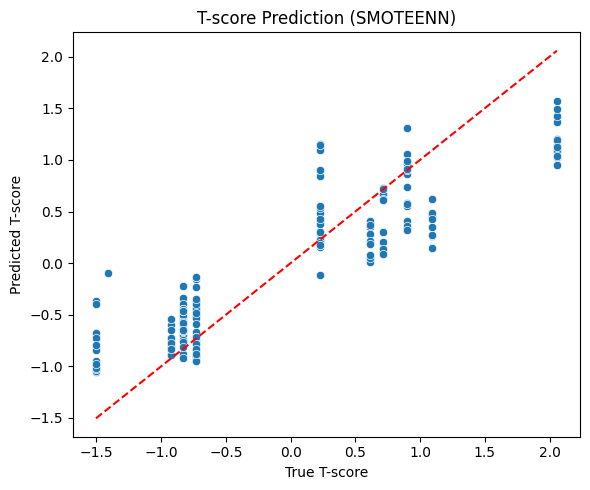

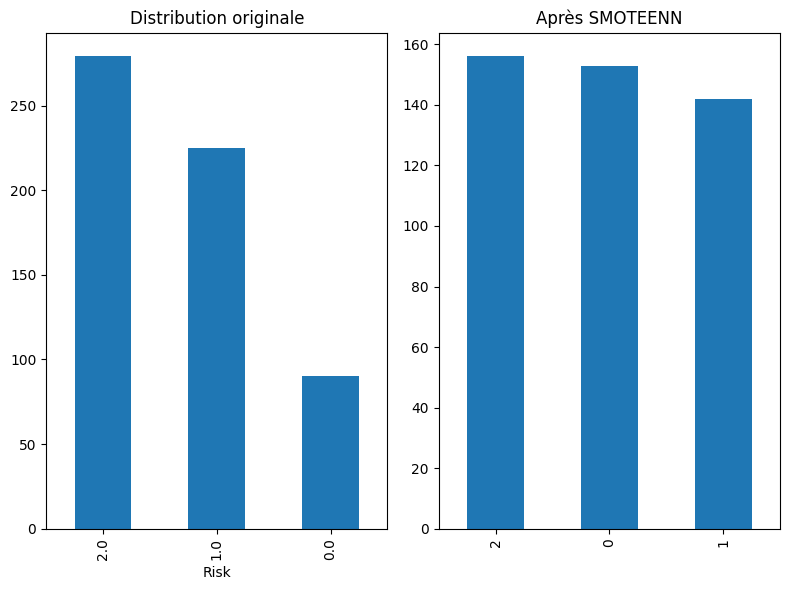

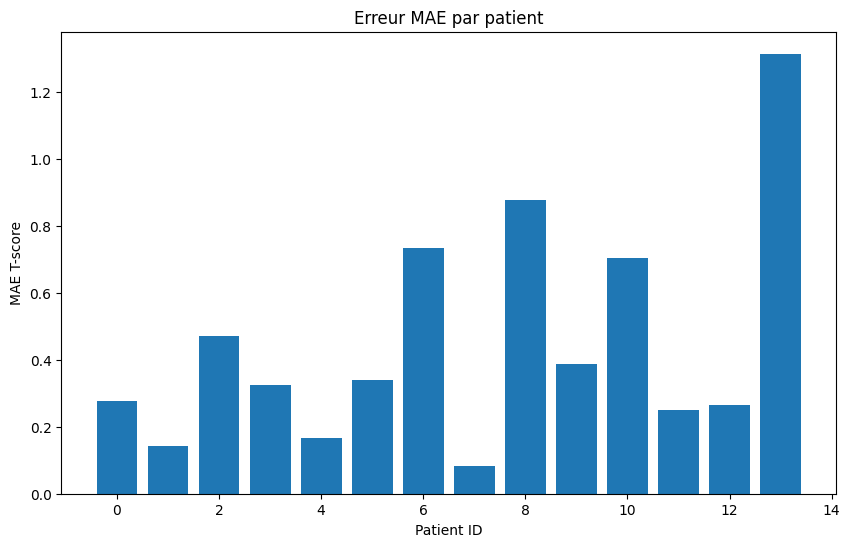

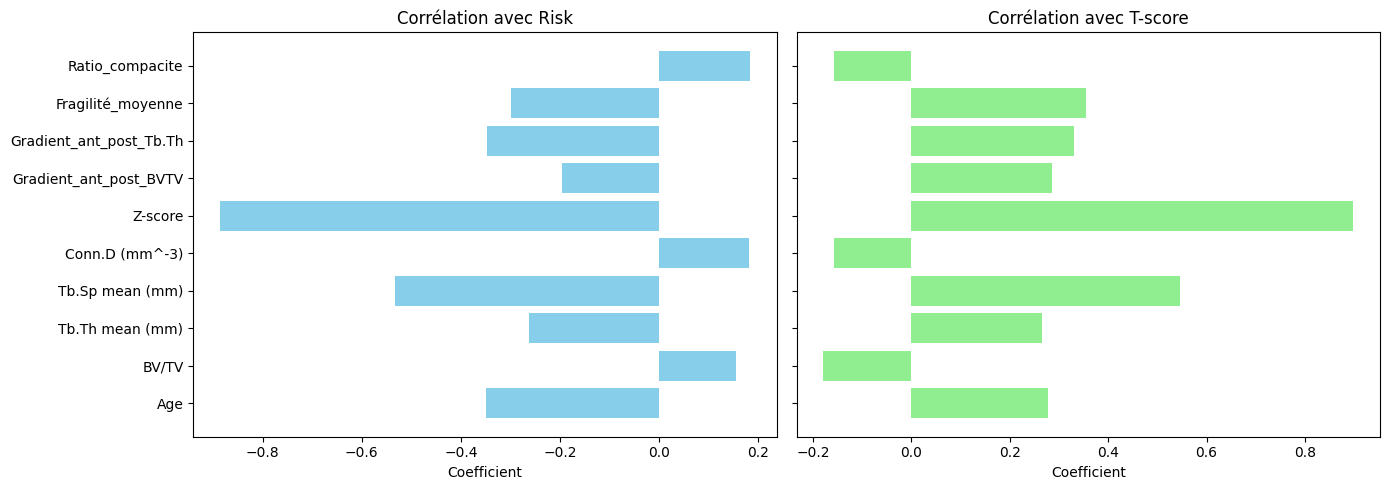

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, mean_absolute_error,
    mean_squared_error, r2_score, accuracy_score, matthews_corrcoef,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.combine import SMOTEENN
from google.colab import files



SEED = 42

# 2. IMPORT DU FICHIER
uploaded = files.upload()
df = pd.read_csv("data_features_standardise.csv")
# Assign Patient IDs
patient_ids = []
for i in range(13):
    patient_ids.extend([i] * 45)
patient_ids.extend([13] * 9)
df["Patient_ID"] = patient_ids

# Features and targets
features = [
    "Age", "BV/TV", "Tb.Th mean (mm)", "Tb.Sp mean (mm)", "Conn.D (mm^-3)",
    "Z-score", "Gradient_ant_post_BVTV", "Gradient_ant_post_Tb.Th",
    "Fragilité_moyenne", "Ratio_compacite"
]
target_class = "Risk"
target_score = "T-score"

# Train/val/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
y_temp = df[target_class].astype(int).values
for train_val_idx, test_idx in sss.split(df[features], y_temp):
    df_trainval = df.iloc[train_val_idx]
    df_test = df.iloc[test_idx]

# Split train/val
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
y_trainval = df_trainval[target_class].astype(int).values
for train_idx, val_idx in sss_val.split(df_trainval[features], y_trainval):
    df_train = df_trainval.iloc[train_idx]
    df_val = df_trainval.iloc[val_idx]

X_train = df_train[features].values
y_train_class = df_train[target_class].astype(int).values
y_train_score = df_train[target_score].values

X_val = df_val[features].values
y_val_class = df_val[target_class].astype(int).values
y_val_score = df_val[target_score].values

X_test = df_test[features].values
y_test_class = df_test[target_class].astype(int).values
y_test_score = df_test[target_score].values

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=SEED)
X_train_res, y_train_class_res = smoteenn.fit_resample(X_train, y_train_class)

# Merge for T-score imputation
df_temp = pd.DataFrame(X_train, columns=features)
df_temp['T-score'] = y_train_score
df_res = pd.DataFrame(X_train_res, columns=features)
df_merged = df_res.merge(df_temp, on=features, how='left')
df_merged['T-score'] = df_merged['T-score'].fillna(df_temp['T-score'].mean())
y_train_score_res = df_merged['T-score'].values

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(zip(np.unique(y_train_class), class_weights))

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Classification model
input_layer = Input(shape=(X_train_res.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)
model_class = Model(inputs=input_layer, outputs=output_layer)
model_class.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_class = model_class.fit(
    X_train_res, y_train_class_res,
    validation_data=(X_val, y_val_class),
    epochs=100, batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=0
)

# Visualisation loss + accuracy (classification)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['loss'], label='Train Loss')
plt.plot(history_class.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss (Classification)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_class.history['accuracy'], label='Train Accuracy')
plt.plot(history_class.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy (Classification)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation classification
y_pred_proba = model_class.predict(X_test)
y_pred_class = np.argmax(y_pred_proba, axis=1)

# Fix ROC AUC shape
y_test_bin = label_binarize(y_test_class, classes=[0, 1, 2])
if y_pred_proba.shape[1] != 3:
    y_pred_proba_fixed = np.zeros((y_pred_proba.shape[0], 3))
    for i, label in enumerate(np.unique(y_train_class)):
        y_pred_proba_fixed[:, label] = y_pred_proba[:, i]
    y_pred_proba = y_pred_proba_fixed

acc = accuracy_score(y_test_class, y_pred_class)
mcc = matthews_corrcoef(y_test_class, y_pred_class)
auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
mae_class = mean_absolute_error(y_test_class, y_pred_class)

print("--- Classification ---")
print(f"Accuracy: {acc:.4f} | MCC: {mcc:.4f} | ROC AUC: {auc:.4f}")
print(classification_report(y_test_class, y_pred_class))
print("Confusion Matrix:")
conf = confusion_matrix(y_test_class, y_pred_class)
print(conf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SMOTEENN)")
plt.tight_layout()
plt.show()

# Regression model
input_layer_reg = Input(shape=(X_train_res.shape[1],))
x_reg = Dense(64, activation='relu')(input_layer_reg)
x_reg = Dense(32, activation='relu')(x_reg)
output_layer_reg = Dense(1)(x_reg)
model_reg = Model(inputs=input_layer_reg, outputs=output_layer_reg)
model_reg.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])
history_reg = model_reg.fit(
    X_train_res, y_train_score_res,
    validation_data=(X_val, y_val_score),
    epochs=100, batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

# Visualisation loss (régression)
plt.figure(figsize=(6, 5))
plt.plot(history_reg.history['loss'], label='Train MSE')
plt.plot(history_reg.history['val_loss'], label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Model Loss (Régression)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation regression
pred_score = model_reg.predict(X_test).flatten()
mae = mean_absolute_error(y_test_score, pred_score)
rmse = np.sqrt(mean_squared_error(y_test_score, pred_score))
r2 = r2_score(y_test_score, pred_score)

print("\n--- Régression ---")
print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test_score, y=pred_score)
plt.plot([min(y_test_score), max(y_test_score)], [min(y_test_score), max(y_test_score)], 'r--')
plt.xlabel("True T-score")
plt.ylabel("Predicted T-score")
plt.title("T-score Prediction (SMOTEENN)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
df['Risk'].value_counts().plot(kind='bar', title='Distribution originale')
plt.subplot(1, 2, 2)
pd.Series(y_train_class_res).value_counts().plot(kind='bar', title='Après SMOTEENN')
plt.tight_layout()

#Analyser la performance par patient
test_patients = df_test['Patient_ID'].values
plt.figure(figsize=(10, 6))
patient_errors = {}
for pid in np.unique(test_patients):
    mask = test_patients == pid
    if np.sum(mask) > 0:
        patient_mae = mean_absolute_error(y_test_score[mask], pred_score[mask])
        patient_errors[pid] = patient_mae

plt.bar(patient_errors.keys(), patient_errors.values())
plt.title('Erreur MAE par patient')
plt.xlabel('Patient ID')
plt.ylabel('MAE T-score')

# Importance des features : corrélation avec Risk et T-score côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Corrélation avec Risk
corr_risk = df[features + ['Risk']].corr()['Risk'].drop('Risk')
axes[0].barh(corr_risk.index, corr_risk.values, color='skyblue')
axes[0].set_title('Corrélation avec Risk')
axes[0].set_xlabel('Coefficient')

# Corrélation avec T-score
corr_tscore = df[features + ['T-score']].corr()['T-score'].drop('T-score')
axes[1].barh(corr_tscore.index, corr_tscore.values, color='lightgreen')
axes[1].set_title('Corrélation avec T-score')
axes[1].set_xlabel('Coefficient')

plt.tight_layout()
plt.show()
